In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os

from skimage import io
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Explanation of dataset

LeakDB (Leakage Diagnosis Benchmark) is a realistic leakage dataset for water distribution networks. The dataset is comprised of a large number of artificially created but realistic leakage scenarios, on different water distribution networks, under varying conditions. Each scneario is a simulation of the Water Distribution system during one year. We have one value each 30 minutes (we have 17520 points in total)

On each scenario we have 4 folders. The *Demands* folder contains the water consumption at the nodes of the network and are measured in $m^3$/hour. \
The *Flows* folder contain the flow of water (in $m^3$/hour) at each link of the network (please refer to the Hanoi Distribution Network image at the top of this notebook.  \
The *Pressures* folder contains all the pressure at each node of the network (in $bars$).  \
To finish, the *Leaks* folder contains information about the leak : where (what node).  \
At the top of the scenario folder, we have a label file (*Labels.csv*) where 0 is for no leakage and 1 is for leakage  \
For our analysis, we are going to concentrate us only on pressures and flows.  \
To train models, we have chosen to use one scenario without leakage (scenario 1), and two scenario with leakage (scenario 5 and scenario 78).

# EDA

To simplify our study, we are going to consider only 1 node : _Node 21_  \.
We chose to create 6 different dataset : for each scenario (we have 3 scenarios), we create one dataset containing pressures values and label (1 for leakage, 0 for no leakage) and one dataset containing flows values with label. For the flows values, as we consider the Node 21, we are going to only consider the Link 21, as shown in the Hanoi Water Distribution System figure : 

Text(0.5, 1.0, 'Hanoi Water Distribution System')

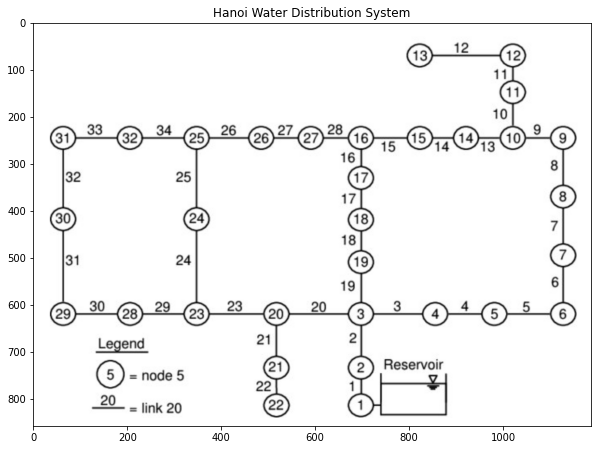

In [95]:
image = io.imread("../data/tx_hanoi.png")
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("Hanoi Water Distribution System")

Let's import all the data we need (this data is an extract from scenario 1, 5 and 78 and we just import absolute values for pressures and flows of the node 21 and the link 21

In [96]:
pressures_no_leakage = pd.read_csv("../data/no_leakage/pressures.csv").drop("Unnamed: 0", axis=1)[[
    "Timestamp",
    "Node_21",
    "label",
]]
pressures_no_leakage["Timestamp"] = pd.to_datetime(pressures_no_leakage["Timestamp"])
flows_no_leakage = pd.read_csv("../data/no_leakage/flows.csv").drop("Unnamed: 0", axis=1)[[
    "Timestamp",
    "Link_21",
    "label",
]]
flows_no_leakage["Timestamp"] = pd.to_datetime(flows_no_leakage["Timestamp"])

pressures_leakage = pd.read_csv("../data/leakage/pressures.csv").drop("Unnamed: 0", axis=1)[[
    "Timestamp",
    "Node_21",
    "label",
]]
pressures_leakage["Timestamp"] = pd.to_datetime(pressures_leakage["Timestamp"])
flows_leakage = pd.read_csv("../data/leakage/flows.csv").drop("Unnamed: 0", axis=1)[[
    "Timestamp",
    "Link_21",
    "label",
]]
flows_leakage["Timestamp"] = pd.to_datetime(flows_leakage["Timestamp"])

pressures_leakage2 = pd.read_csv("../data/leakage/pressures3_bis.csv").drop("Unnamed: 0", axis=1)[[
    "Timestamp",
    "Node_21",
    "label",
]]
pressures_leakage2["Timestamp"] = pd.to_datetime(pressures_leakage2["Timestamp"])
flows_leakage2 = pd.read_csv("../data/leakage/flows3_bis.csv").drop("Unnamed: 0", axis=1)[[
    "Timestamp",
    "Link_21",
    "label",
]]
flows_leakage2["Timestamp"] = pd.to_datetime(flows_leakage2["Timestamp"])

Here is one example of the dataframes we have:  \
**Pressures in scenario without leakage**

In [97]:
pressures_no_leakage.head()

,Timestamp,Node_21,label
0,2017-01-01 00:00:00,67.024,0.0
1,2017-01-01 00:30:00,67.691,0.0
2,2017-01-01 01:00:00,68.112,0.0
3,2017-01-01 01:30:00,68.441,0.0
4,2017-01-01 02:00:00,68.688,0.0


**Flows in scenario without leakage**

In [98]:
flows_no_leakage.head()

,Timestamp,Link_21,label
0,2017-01-01 00:00:00,205.2,0.0
1,2017-01-01 00:30:00,194.4,0.0
2,2017-01-01 01:00:00,172.8,0.0
3,2017-01-01 01:30:00,147.6,0.0
4,2017-01-01 02:00:00,133.2,0.0


## Distribution

Here are the distributions of the pressures and the flows according to each scenario

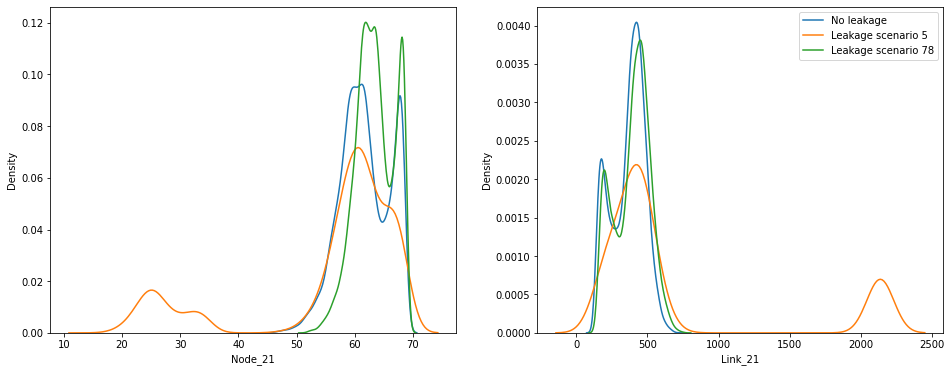

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.kdeplot(data=pressures_no_leakage, x="Node_21", label="No leakage", ax=axes[0])
sns.kdeplot(data=pressures_leakage, x="Node_21", label="Leakage scenario 5", ax=axes[0])
sns.kdeplot(data=pressures_leakage2, x="Node_21", label="Leakage scenario 78", ax=axes[0])

sns.kdeplot(data=flows_no_leakage, x="Link_21", label="No leakage", ax=axes[1])
sns.kdeplot(data=flows_leakage, x="Link_21", label="Leakage scenario 5", ax=axes[1])
sns.kdeplot(data=flows_leakage2, x="Link_21", label="Leakage scenario 78", ax=axes[1])

plt.legend()
plt.show()

We can see that we don't have a normal distribution, so we don't have a white noise serie for pressions and for flows

It seems we have ponctual anomalies (seeing the distribution of the scenario 5 in orange) and contextual and collective anomalies (according to the distribution of the scenario 78)

## Visualization of time series

Let's plot 2 weeks data to visualize the time series

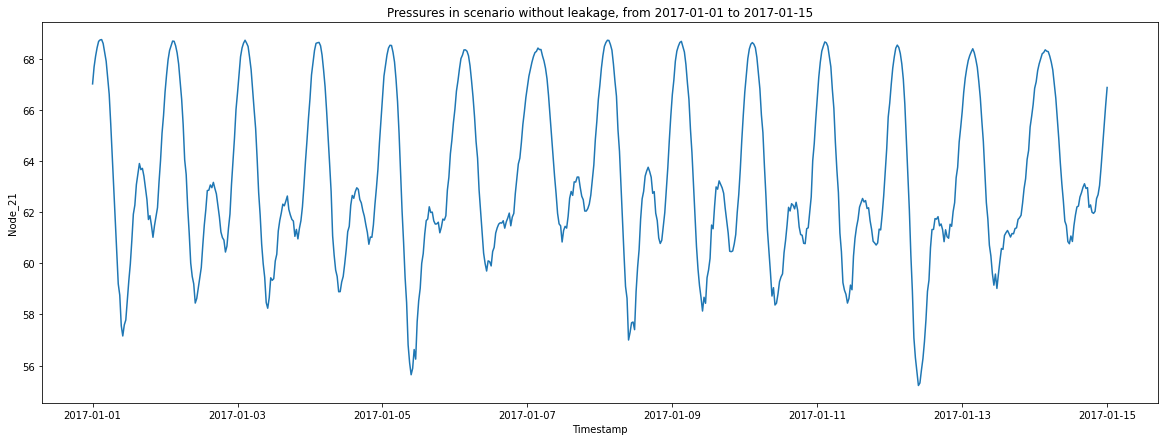

In [100]:
plt.figure(figsize=(20, 7))
sns.lineplot(
    data=pressures_no_leakage[pressures_no_leakage["Timestamp"] <= "2017-01-15 00:00:00"],
    x="Timestamp",
    y="Node_21"
)
plt.title("Pressures in scenario without leakage, from 2017-01-01 to 2017-01-15")
plt.show()

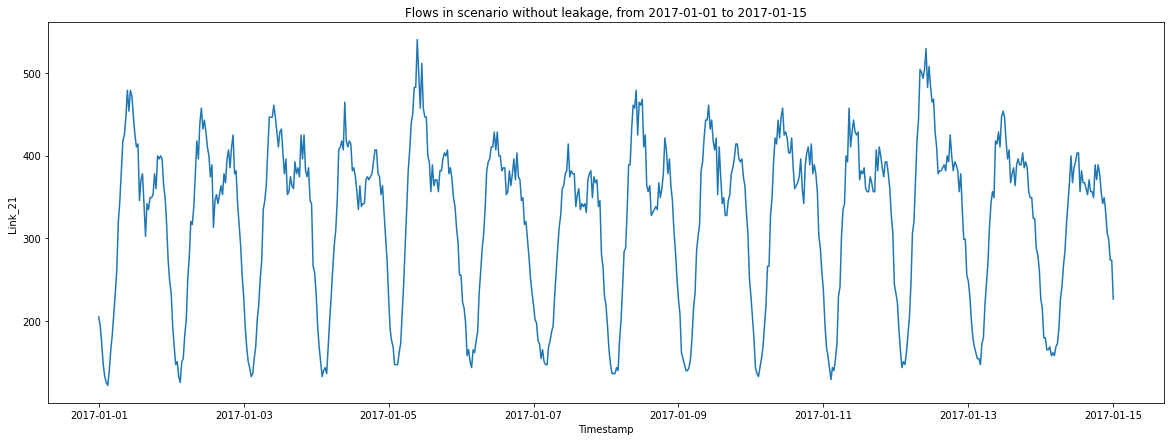

In [101]:
plt.figure(figsize=(20, 7))
sns.lineplot(
    data=flows_no_leakage[flows_no_leakage["Timestamp"] <= "2017-01-15 00:00:00"],
    x="Timestamp",
    y="Link_21"
)
plt.title("Flows in scenario without leakage, from 2017-01-01 to 2017-01-15")
plt.show()

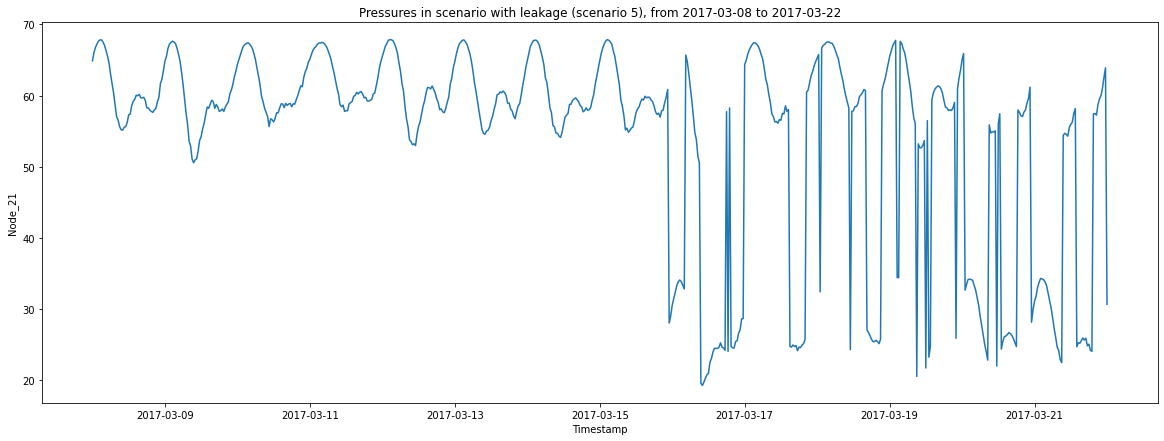

In [102]:
plt.figure(figsize=(20, 7))
sns.lineplot(
    data=pressures_leakage[(pressures_leakage["Timestamp"] >= "2017-03-08 00:00:00") & (pressures_leakage["Timestamp"] <= "2017-03-22 00:00:00")],
    x="Timestamp",
    y="Node_21"
)
plt.title("Pressures in scenario with leakage (scenario 5), from 2017-03-08 to 2017-03-22")
plt.show()

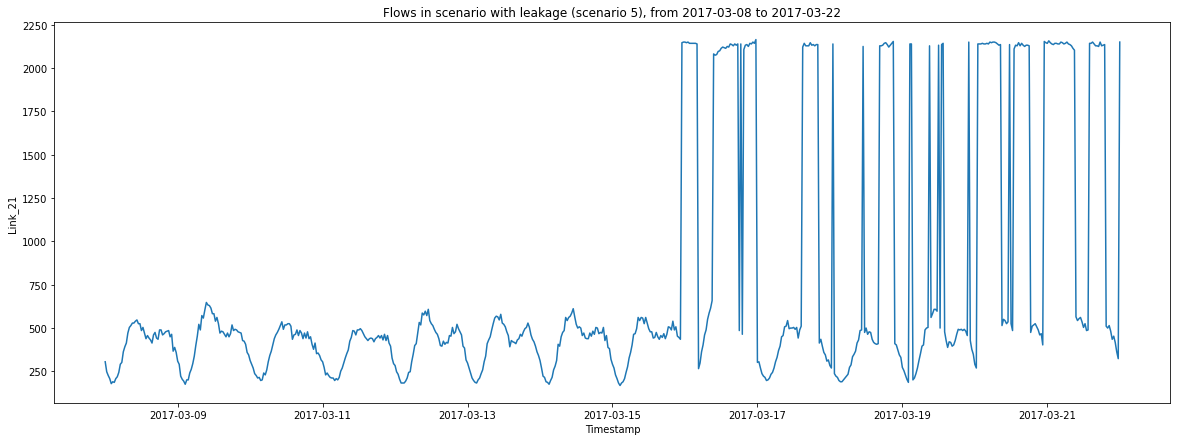

In [103]:
plt.figure(figsize=(20, 7))
sns.lineplot(
    data=flows_leakage[(flows_leakage["Timestamp"] >= "2017-03-08 00:00:00") & (flows_leakage["Timestamp"] <= "2017-03-22 00:00:00")],
    x="Timestamp",
    y="Link_21"
)
plt.title("Flows in scenario with leakage (scenario 5), from 2017-03-08 to 2017-03-22")
plt.show()

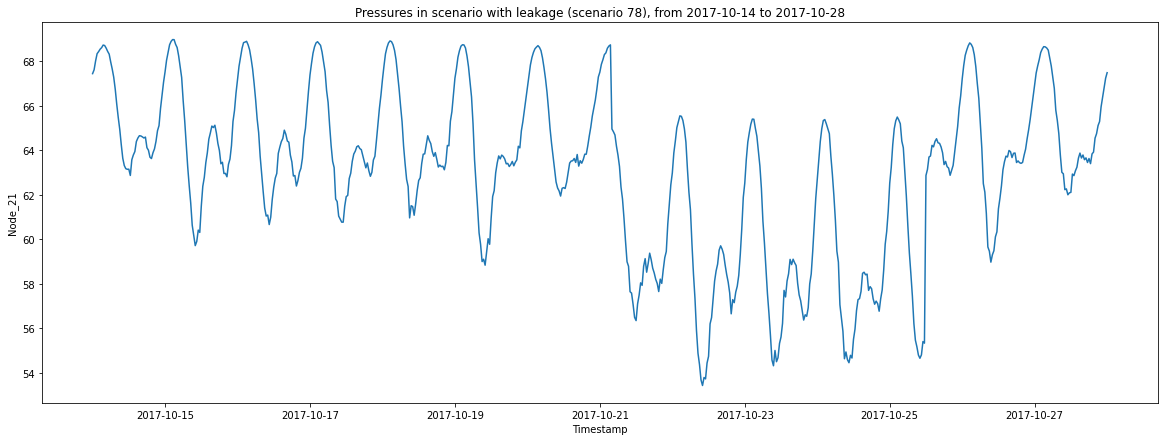

In [104]:
plt.figure(figsize=(20, 7))
sns.lineplot(
    data=pressures_leakage2[(pressures_leakage2["Timestamp"] >= "2017-10-14 00:00:00") & (pressures_leakage2["Timestamp"] <= "2017-10-28 00:00:00")],
    x="Timestamp",
    y="Node_21"
)
plt.title("Pressures in scenario with leakage (scenario 78), from 2017-10-14 to 2017-10-28")
plt.show()

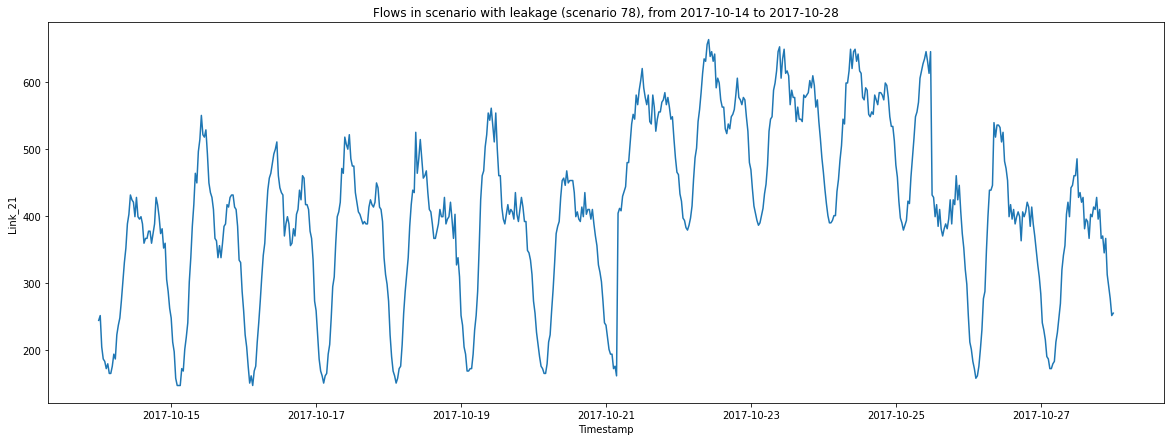

In [105]:
plt.figure(figsize=(20, 7))
sns.lineplot(
    data=flows_leakage2[(flows_leakage2["Timestamp"] >= "2017-10-14 00:00:00") & (flows_leakage2["Timestamp"] <= "2017-10-28 00:00:00")],
    x="Timestamp",
    y="Link_21"
)
plt.title("Flows in scenario with leakage (scenario 78), from 2017-10-14 to 2017-10-28")
plt.show()

All these plots confirm the hypotesis we did above : we have ponctual, contextual and collective anomalies. in addition, we can determine that we have a daily seasonnality in our 2 time series. We have then to implement a model capable of detecting all these kinds of anomalies

# Model chosen

We decide to implement the following model : 

1)  Raw data is aggregated all 3 hours and we create the 5 following features : mean, std, median, min, max

2) With a trained SARIMA model on a scenario without anomalies, we will predict the mean value of the 3 hour aggregation we would normally have, and we calculate the difference between the predicted value and the actual value

3) We classify with a trained classification model if the aggregation is an anomaly or not

This model is summarize on the graph below:

Text(0.5, 1.0, 'Model summary')

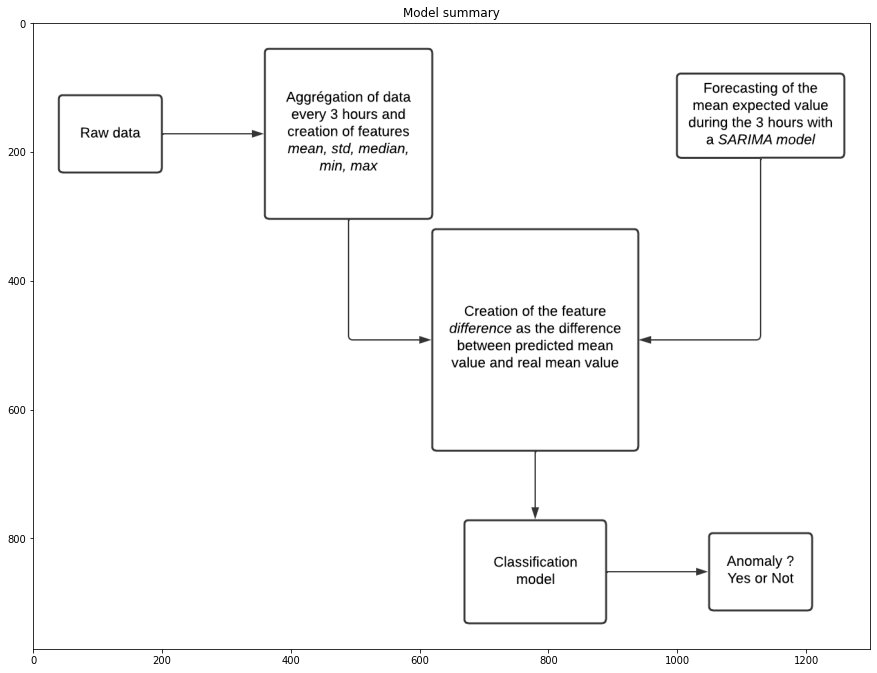

In [106]:
summary = io.imread("../data/model_summary.png")
plt.figure(figsize=(15, 15))
plt.imshow(summary, cmap="gray")
plt.title("Model summary")

# Aggregation of data

In [107]:
pressures_no_leakage3h_mean = pressures_no_leakage.groupby(pd.Grouper(
    key="Timestamp", axis=0, freq="3h")).agg(
    node_21_mean = ("Node_21", "mean"),
    node_21_std = ("Node_21", "std"),
    node_21_median = ("Node_21", "median"),
    node_21_min = ("Node_21", "min"),
    node_21_max = ("Node_21", "max"),
    label = ("label", "max")
)
flows_no_leakage3h_mean = flows_no_leakage.groupby(pd.Grouper(
    key="Timestamp", axis=0, freq="3h")).agg(
    link_21_mean = ("Link_21", "mean"),
    link_21_std = ("Link_21", "std"),
    link_21_median = ("Link_21", "median"),
    link_21_min = ("Link_21", "min"),
    link_21_max = ("Link_21", "max"),
    label = ("label", "max")
)

pressures_leakage3h_mean = pressures_leakage.groupby(pd.Grouper(
    key="Timestamp", axis=0, freq="3h")).agg(
    node_21_mean = ("Node_21", "mean"),
    node_21_std = ("Node_21", "std"),
    node_21_median = ("Node_21", "median"),
    node_21_min = ("Node_21", "min"),
    node_21_max = ("Node_21", "max"),
    label = ("label", "max")
)
flows_leakage3h_mean = flows_leakage.groupby(pd.Grouper(
    key="Timestamp", axis=0, freq="3h")).agg(
    link_21_mean = ("Link_21", "mean"),
    link_21_std = ("Link_21", "std"),
    link_21_median = ("Link_21", "median"),
    link_21_min = ("Link_21", "min"),
    link_21_max = ("Link_21", "max"),
    label = ("label", "max")
)

pressures_leakage2_3h_mean = pressures_leakage2.groupby(pd.Grouper(
    key="Timestamp", axis=0, freq="3h")).agg(
    node_21_mean = ("Node_21", "mean"),
    node_21_std = ("Node_21", "std"),
    node_21_median = ("Node_21", "median"),
    node_21_min = ("Node_21", "min"),
    node_21_max = ("Node_21", "max"),
    label = ("label", "max")
)
flows_leakage2_3h_mean = flows_leakage2.groupby(pd.Grouper(
    key="Timestamp", axis=0, freq="3h")).agg(
    link_21_mean = ("Link_21", "mean"),
    link_21_std = ("Link_21", "std"),
    link_21_median = ("Link_21", "median"),
    link_21_min = ("Link_21", "min"),
    link_21_max = ("Link_21", "max"),
    label = ("label", "max")
)

The 6 dataframes we have created at the begining have now this shape:  \
**Pressures in a scenario with a leakage (scenario 78)**

In [108]:
pressures_leakage2_3h_mean.head()

,node_21_mean,node_21_std,node_21_median,node_21_min,node_21_max,label
Timestamp,,,,,,
2017-01-01 00:00:00,68.489833,0.519958,68.6015,67.671,69.003,0.0
2017-01-01 03:00:00,68.315667,0.648102,68.4790,67.270,68.950,0.0
2017-01-01 06:00:00,64.207333,1.730681,64.1020,61.946,66.537,0.0
2017-01-01 09:00:00,60.808000,0.421007,60.8310,60.215,61.331,0.0
2017-01-01 12:00:00,63.290333,1.044928,63.2585,61.716,64.553,0.0


## Distributions

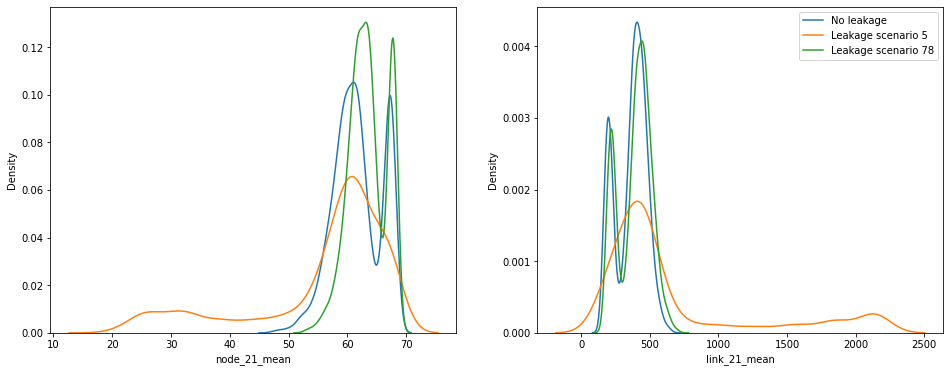

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.kdeplot(data=pressures_no_leakage3h_mean, x="node_21_mean", label="No leakage", ax=axes[0])
sns.kdeplot(data=pressures_leakage3h_mean, x="node_21_mean", label="Leakage scenario 5", ax=axes[0])
sns.kdeplot(data=pressures_leakage2_3h_mean, x="node_21_mean", label="Leakage scenario 78", ax=axes[0])

sns.kdeplot(data=flows_no_leakage3h_mean, x="link_21_mean", label="No leakage", ax=axes[1])
sns.kdeplot(data=flows_leakage3h_mean, x="link_21_mean", label="Leakage scenario 5", ax=axes[1])
sns.kdeplot(data=flows_leakage2_3h_mean, x="link_21_mean", label="Leakage scenario 78", ax=axes[1])

plt.legend()
plt.show()

## Visualization

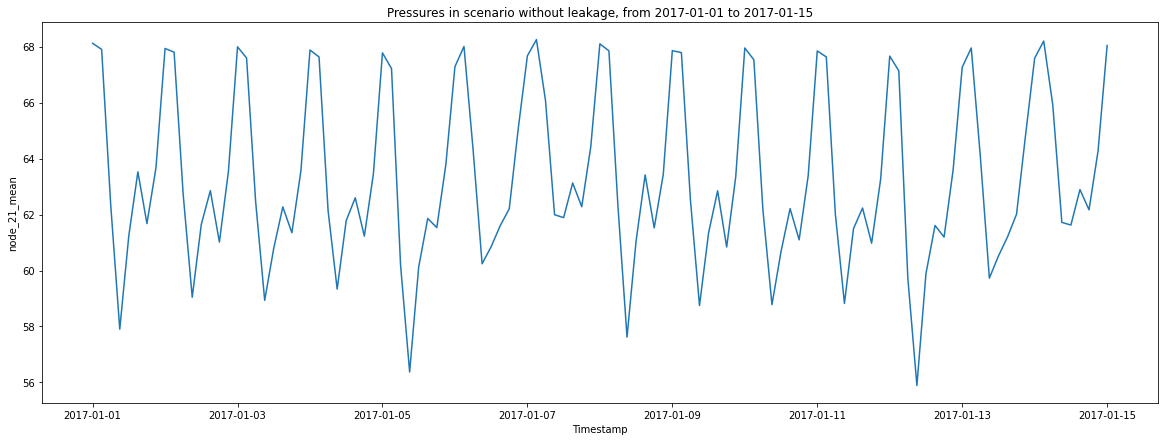

In [110]:
plt.figure(figsize=(20, 7))
sns.lineplot(
    data=pressures_no_leakage3h_mean[pressures_no_leakage3h_mean.index <= "2017-01-15 00:00:00"],
    x="Timestamp",
    y="node_21_mean"
)
plt.title("Pressures in scenario without leakage, from 2017-01-01 to 2017-01-15")
plt.show()

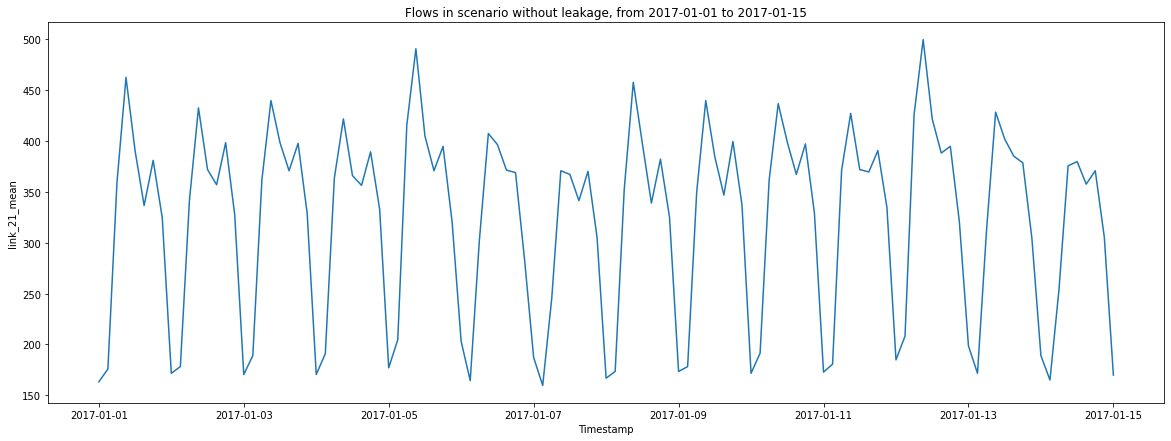

In [111]:
plt.figure(figsize=(20, 7))
sns.lineplot(
    data=flows_no_leakage3h_mean[flows_no_leakage3h_mean.index <= "2017-01-15 00:00:00"],
    x="Timestamp",
    y="link_21_mean"
)
plt.title("Flows in scenario without leakage, from 2017-01-01 to 2017-01-15")
plt.show()

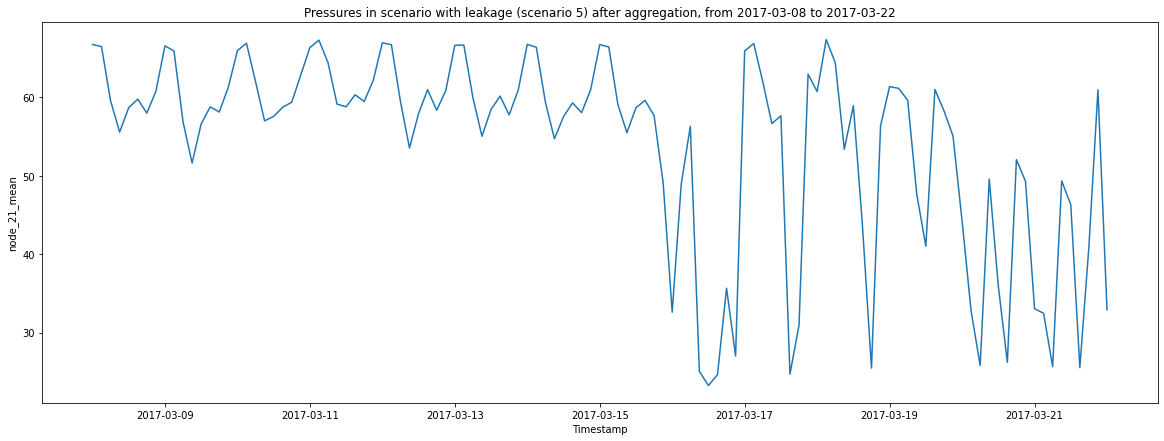

In [112]:
plt.figure(figsize=(20, 7))
sns.lineplot(
    data=pressures_leakage3h_mean[(pressures_leakage3h_mean.index >= "2017-03-08 00:00:00") & (pressures_leakage3h_mean.index <= "2017-03-22 00:00:00")],
    x=pressures_leakage3h_mean[(pressures_leakage3h_mean.index >= "2017-03-08 00:00:00") & (pressures_leakage3h_mean.index <= "2017-03-22 00:00:00")].index,
    y="node_21_mean"
)
plt.title("Pressures in scenario with leakage (scenario 5) after aggregation, from 2017-03-08 to 2017-03-22")
plt.show()

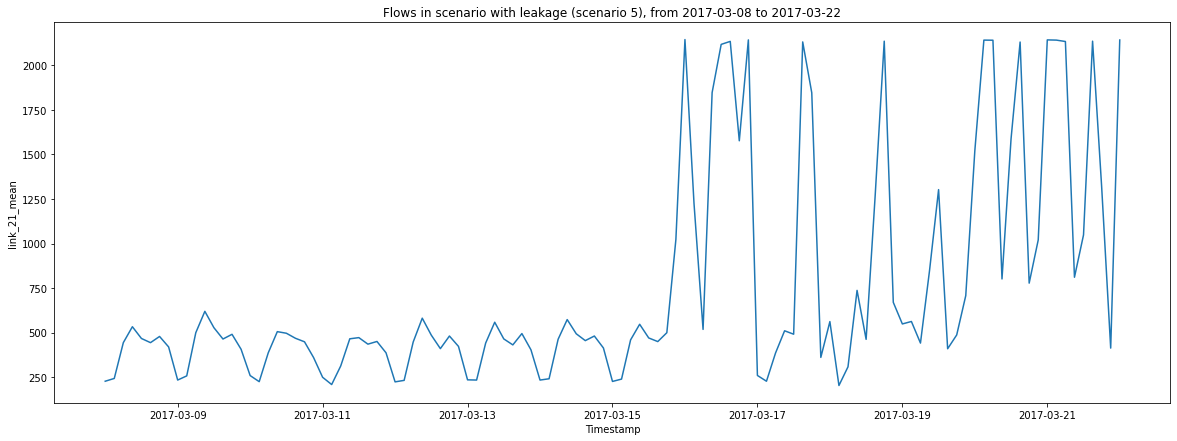

In [113]:
plt.figure(figsize=(20, 7))
sns.lineplot(
    data=flows_leakage3h_mean[(flows_leakage3h_mean.index >= "2017-03-08 00:00:00") & (flows_leakage3h_mean.index <= "2017-03-22 00:00:00")],
    x="Timestamp",
    y="link_21_mean"
)
plt.title("Flows in scenario with leakage (scenario 5), from 2017-03-08 to 2017-03-22")
plt.show()

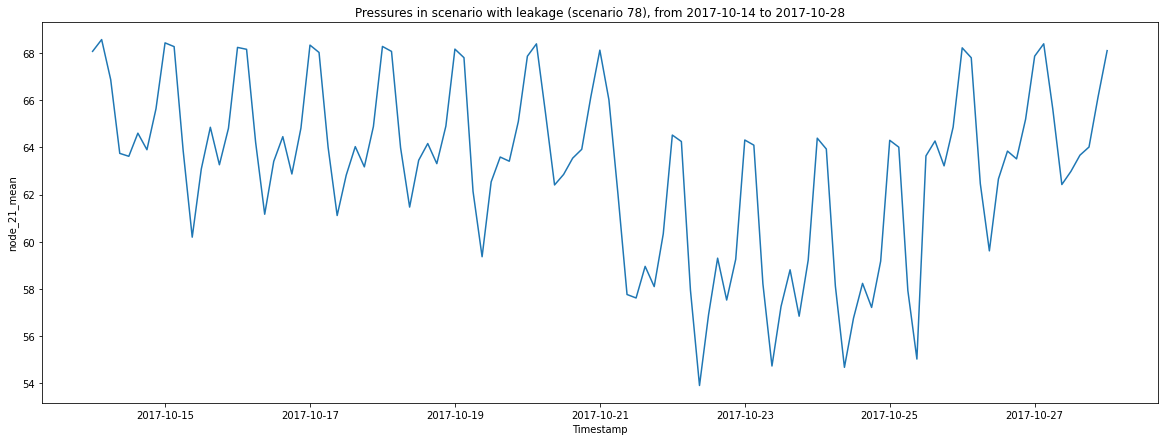

In [114]:
plt.figure(figsize=(20, 7))
sns.lineplot(
    data=pressures_leakage2_3h_mean[(pressures_leakage2_3h_mean.index >= "2017-10-14 00:00:00") & (pressures_leakage2_3h_mean.index <= "2017-10-28 00:00:00")],
    x="Timestamp",
    y="node_21_mean"
)
plt.title("Pressures in scenario with leakage (scenario 78), from 2017-10-14 to 2017-10-28")
plt.show()

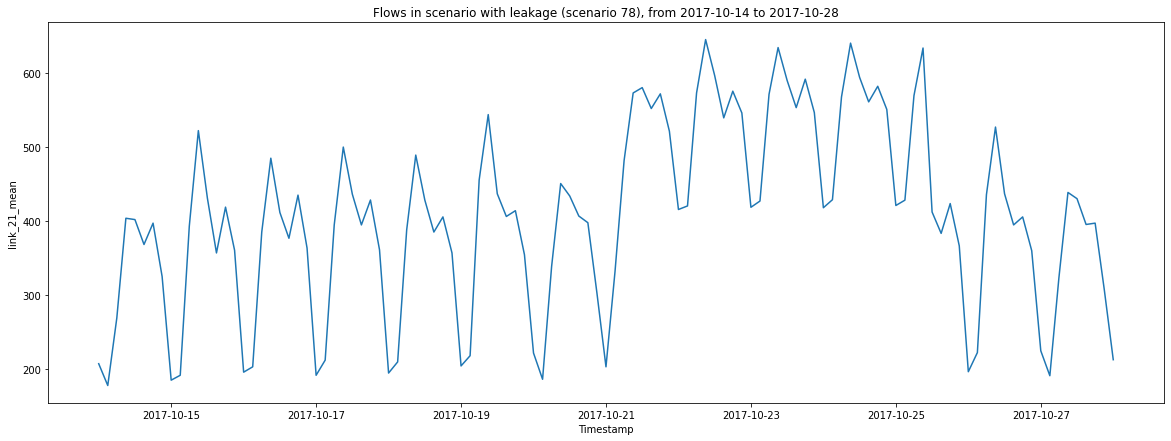

In [115]:
plt.figure(figsize=(20, 7))
sns.lineplot(
    data=flows_leakage2_3h_mean[(flows_leakage2_3h_mean.index >= "2017-10-14 00:00:00") & (flows_leakage2_3h_mean.index <= "2017-10-28 00:00:00")],
    x="Timestamp",
    y="link_21_mean"
)
plt.title("Flows in scenario with leakage (scenario 78), from 2017-10-14 to 2017-10-28")
plt.show()

# Seasonal decomposition

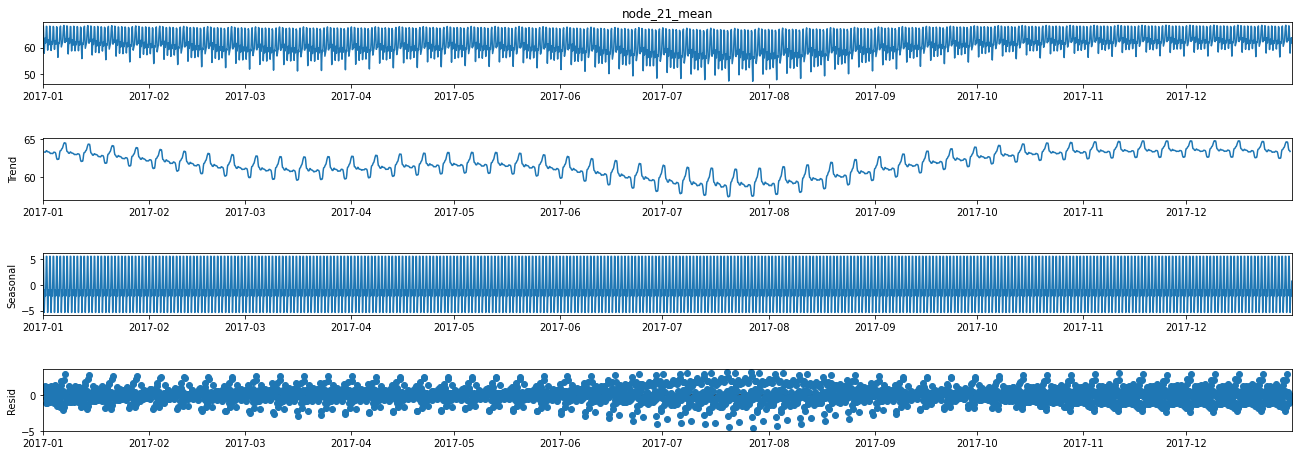

In [116]:
seasonam = seasonal_decompose(pressures_no_leakage3h_mean["node_21_mean"], period=8)
fig = seasonam.plot()
fig.set_size_inches(20, 7)
plt.show()

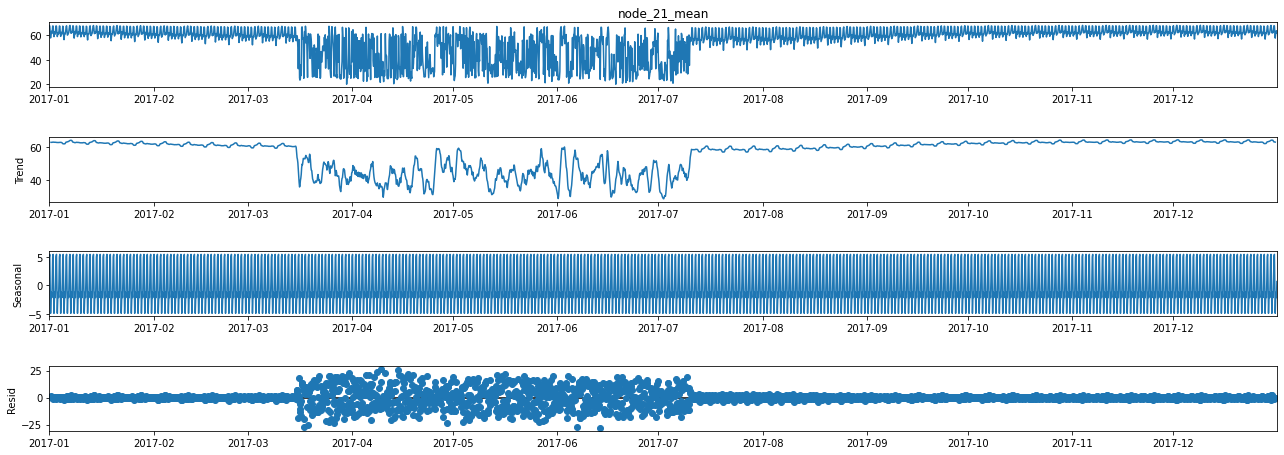

In [117]:
seasonam = seasonal_decompose(pressures_leakage3h_mean["node_21_mean"], period=8)
fig = seasonam.plot()
fig.set_size_inches(20, 7)
plt.show()

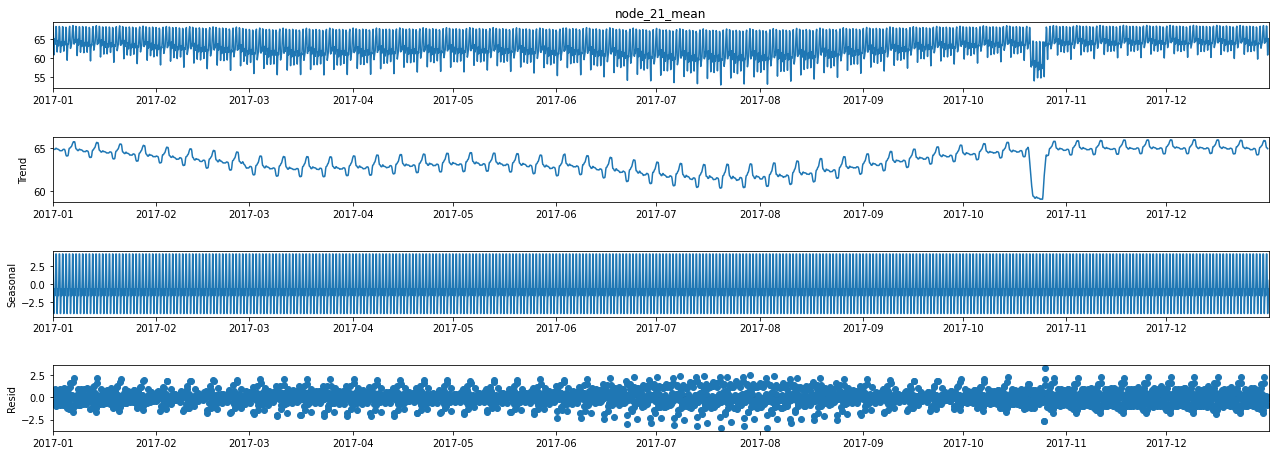

In [118]:
seasonam = seasonal_decompose(pressures_leakage2_3h_mean["node_21_mean"], period=8)
fig = seasonam.plot()
fig.set_size_inches(20, 7)
plt.show()

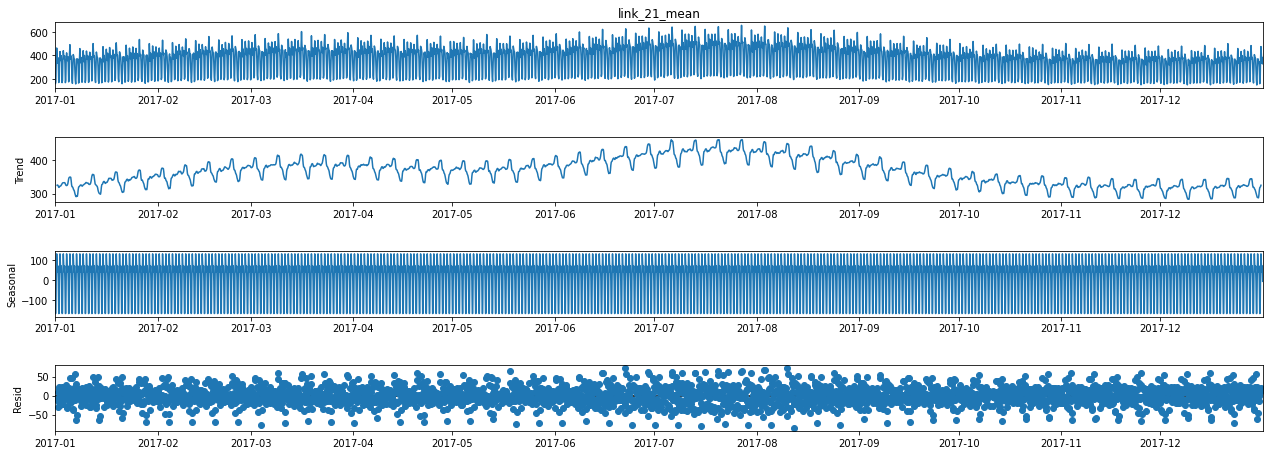

In [119]:
seasonam = seasonal_decompose(flows_no_leakage3h_mean["link_21_mean"], period=8)
fig = seasonam.plot()
fig.set_size_inches(20, 7)
plt.show()

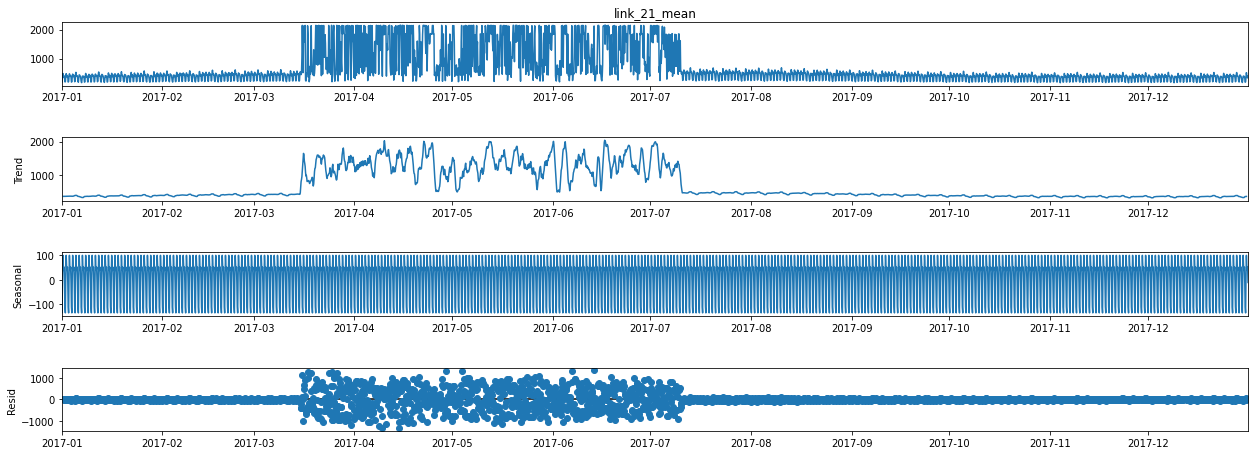

In [120]:
seasonam = seasonal_decompose(flows_leakage3h_mean["link_21_mean"], period=8)
fig = seasonam.plot()
fig.set_size_inches(20, 7)
plt.show()

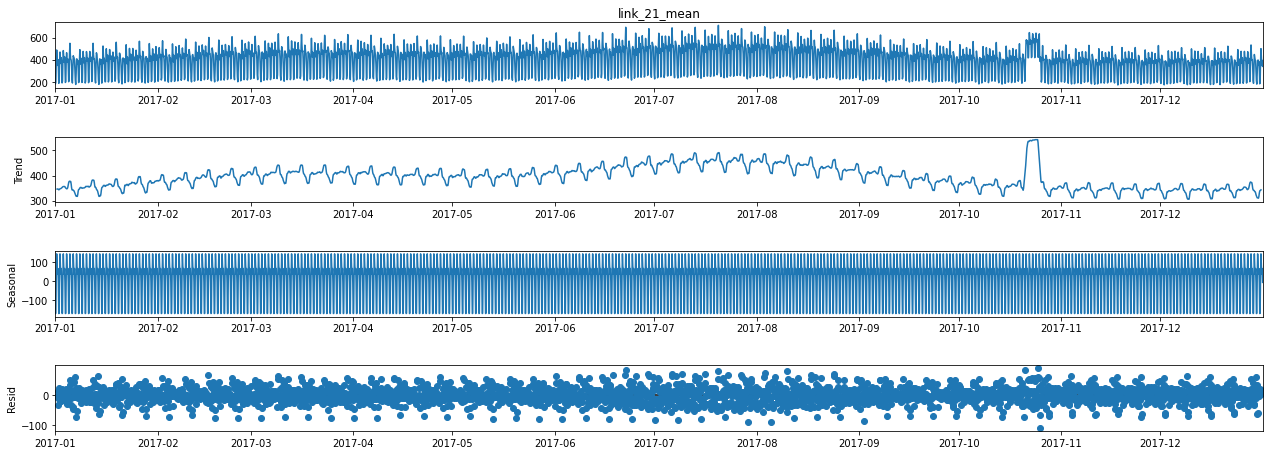

In [121]:
seasonam = seasonal_decompose(flows_leakage2_3h_mean["link_21_mean"], period=8)
fig = seasonam.plot()
fig.set_size_inches(20, 7)
plt.show()

# Save dataframes

In [122]:
pressures_no_leakage3h_mean.to_csv("../data/aggregation/pressures_aggregated_scenario1.csv")
pressures_leakage3h_mean.to_csv("../data/aggregation/pressures_aggregated_scenario5.csv")
pressures_leakage2_3h_mean.to_csv("../data/aggregation/pressures_aggregated_scenario78.csv")

flows_no_leakage3h_mean.to_csv("../data/aggregation/flows_aggregated_scenario1.csv")
flows_leakage3h_mean.to_csv("../data/aggregation/flows_aggregated_scenario5.csv")
flows_leakage2_3h_mean.to_csv("../data/aggregation/flows_aggregated_scenario78.csv")